In [85]:
# Рабочий вариант, но без torch
# Преоразовать существующий код для распознавания последовательности рукописных символов в текст.
# Написать генератор произвольной последовательности рукописных символов.

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
# Сгенерировать набор текстовых строк из допустимых символов.
# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
# Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

# КЛАССИФИКАЦИЯ (k ближайших соседей)
# Часть символов оставить для обучения классификатора . Остальные  классифицировать
# по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
# Выбрать оптимальный классификатор в зависимости от k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

# РАСПОЗНАВАНИЕ
# Итак, к данному этапу Вы из массива изображений "восстановили" текст.
# Случайно удалите некоторые символы,и случайно добавьте символы в результат распознавания.
# Рассчитайте метрику CER.


In [86]:
COUNT_NUMBERS_IN_STRINGS = 10
COUNT_STRINGS = 10

In [87]:
import os
import random

directory = 'data'
symbols = [f.replace('times', 'T') for f in os.listdir(directory)]
strings = [' '.join(''.join(random.choices(symbols, k=random.randint(3, 5))) for _ in range(2)) for _ in range(10)]

print(f"Symbols: {symbols}\nStrings: {strings}")

Symbols: ['T', '9', '0', '7', '+', ',', '6', '1', '8', 't', '-', 'h', '(', '4', 'X', '3', ')', '2', 'y', '5', 'w']
Strings: ['727t0 06t)1', '(5y w(1', '128 wy99(', 'X51T) 2hh', '+(69y 2(1', '+4,9) 51)', '4yTh( 410', '56w5 (3y17', '5)X t,))', 'T,t5 89-']


In [88]:
from PIL import Image
def combine_images_with_spaces(images, min_scale=0.8, max_scale=0.9, max_offset=50, spacing=10, space_width=20):
    scaled_images = []

    for img_path in images:
        if img_path == 'space':
            space_img = Image.new('RGB', (space_width, 1), (255, 255, 255))
            scaled_images.append(space_img)
        else:
            img = Image.open(img_path)
            scale = random.uniform(min_scale, max_scale)
            img = img.resize((int(img.width * scale), int(img.height * scale)), Image.LANCZOS)
            scaled_images.append(img)

    total_width = sum(img.width for img in scaled_images) + spacing * (len(scaled_images) - 1)
    max_height = max(img.height for img in scaled_images) + max_offset
    combined_image = Image.new('RGB', (total_width, max_height), (255, 255, 255))

    x_offset = 0
    for img in scaled_images:
        y_offset = random.randint(0, max_offset)
        combined_image.paste(img, (x_offset, y_offset))
        x_offset += img.width + spacing

    return combined_image

In [89]:
def get_symb_images_paths_map():
    symbol_images = {}
    for symbol in symbols:
        folder = os.path.join(directory, symbol if symbol != 'times' else 'T')
        symbol_images[symbol] = [os.path.join(folder, img) for img in os.listdir(folder)]
    return symbol_images

In [90]:
def get_string_images_paths_map(symb_images):
    string_images = {}
    for string in strings:
        images = [
            symb_images[char][random.randint(0, len(symb_images[char]) - 1)] if char != ' ' else 'space'
            for char in string
        ]
        string_images[string] = images
    return string_images

In [91]:
symbol_images = get_symb_images_paths_map()
string_images = get_string_images_paths_map(symbol_images)

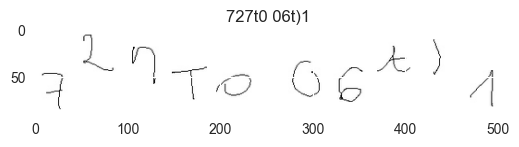

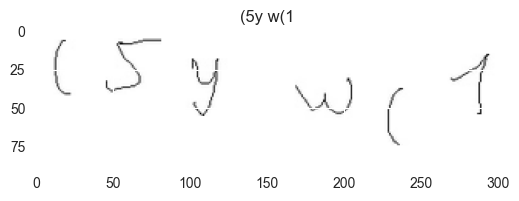

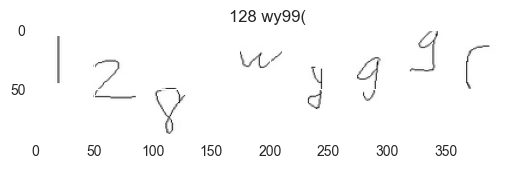

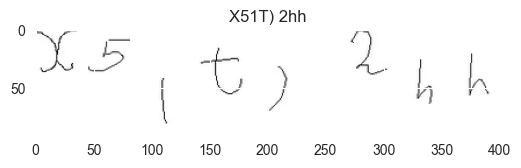

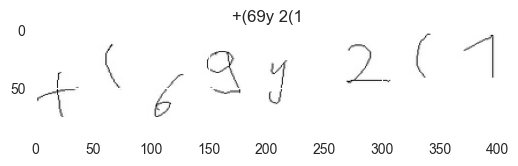

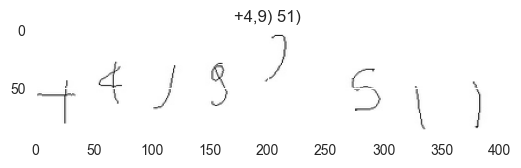

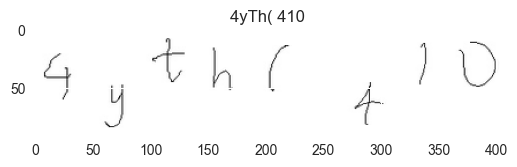

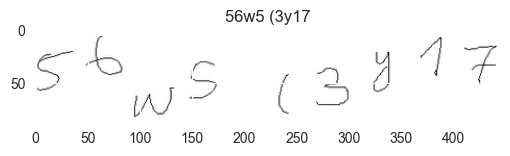

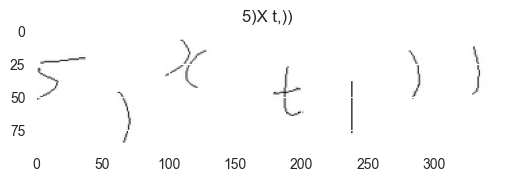

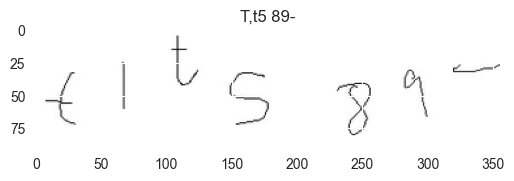

In [92]:

output_directory = 'generated_images'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

generated_images_paths = {}

import matplotlib.pyplot as plt
for i, (string, images) in enumerate(string_images.items(), start=1):
    combined_image = combine_images_with_spaces(images)

    image_path = f'{output_directory}/{i}.png'
    combined_image.save(image_path)

    generated_images_paths[string] = image_path

    plt.figure(figsize=(6, 6))
    plt.imshow(combined_image)
    plt.title(string)
    plt.show()

In [93]:
import cv2
import numpy as np

def get_cv_image(image):
    # если дан путь к изображению
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

    # если дано изобажение PIL
    else:
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

    return image

def get_vector(image):
    image = get_cv_image(image)

    _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        return cv2.resize(image[y:y+h, x:x+w], (32, 32)).flatten()

    # Возвращаем пустой вектор фиксированной длины, если контуры не найдены
    return np.zeros(32 * 32)  # Изменено на 32*32

In [94]:
def prepare_data():
    # Сбор данных
    X = []
    y = []

    # Проходим по каждой папке, соответствующей метке
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            # Обрабатываем каждый файл изображения в папке метки
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Ошибка загрузки изображения: {img_path}")
                    continue
                # Изменяем размер изображения на 32x32 пикселя
                img = cv2.resize(img, (32, 32))
                # Преобразуем изображение в одномерный массив и добавляем в X
                X.append(img.flatten())
                # Добавляем метку изображения в y
                y.append(label)

    return np.array(X), np.array(y)

In [95]:
from sklearn.model_selection import train_test_split
X, y = prepare_data()

Ошибка загрузки изображения: data/8/1


In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def find_optimal_k(X_train, y_train, k_range=(1, 3)):
    param_grid = {'n_neighbors': list(range(k_range[0], k_range[1] + 1))}
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    return grid_search.best_params_['n_neighbors']

In [98]:
optimal_k = find_optimal_k(X_train, y_train)

print(f"Optimal k = {optimal_k}")

Optimal k = 1


In [99]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           (       0.98      1.00      0.99      2800
           )       0.98      1.00      0.99      2958
           +       1.00      0.99      0.99      5005
           ,       0.87      0.93      0.90       388
           -       0.99      1.00      1.00      6875
           0       1.00      1.00      1.00      1323
           1       0.98      0.99      0.98      5210
           2       1.00      0.99      0.99      5324
           3       0.99      0.99      0.99      2156
           4       1.00      0.99      0.99      1503
           5       0.97      0.98      0.98       713
           6       1.00      0.95      0.98       627
           7       0.99      0.97      0.98       584
           8       1.00      0.96      0.98       643
           9       1.00      0.42      0.59       108
           X       1.00      0.99      1.00      5237
           h       1.00      0.99      0.99       318
           t       0.99    

In [100]:
import pickle

model_path = 'knn_model.pkl'
with open(model_path, 'wb') as model_file:
    pickle.dump(knn, model_file)

In [101]:
def extract_symbols(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)[1]

    dilated = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
    rects = [cv2.boundingRect(c) for c in cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]]

    rects.sort(key=lambda r: r[0])

    symbols = [get_vector(image[y:y+h, x:x+w]) for (x, y, w, h) in rects]

    for (x, y, w, h) in rects:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

    return symbols

In [102]:
import editdistance

def calculate_cer(true_text, predicted_text):
    return editdistance.eval(true_text, predicted_text) / len(true_text) if len(true_text) > 0 else 0

In [103]:
import pickle

results = []

def restore_text_from_image(image_path, model, true_string, max_symbols_per_string=10):

    symbol_vectors = extract_symbols(image_path)

    predicted_symbols = model.predict(symbol_vectors)

    restored_text = ''.join(predicted_symbols)
    cer = calculate_cer(true_string, restored_text)
    results.append((true_string, predicted_symbols, cer))

    restored_text = ''.join(predicted_symbols)
    return restored_text, cer


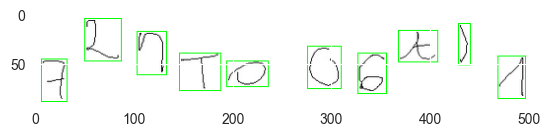

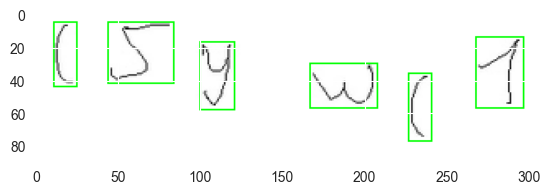

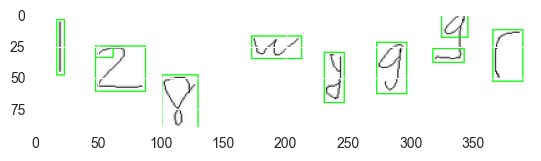

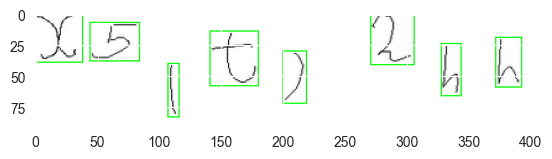

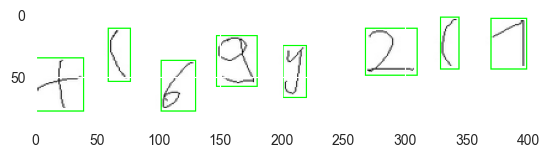

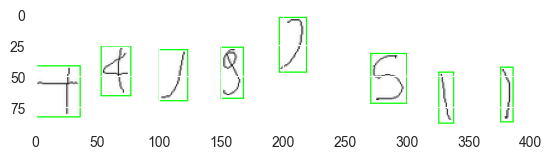

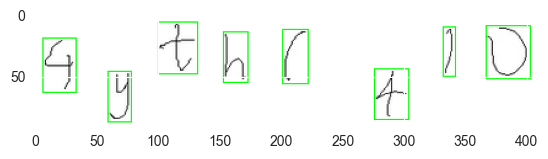

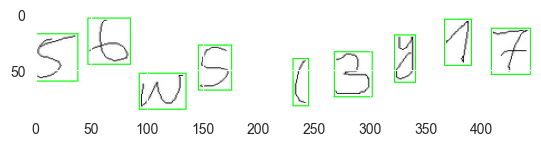

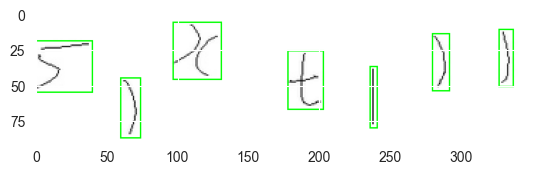

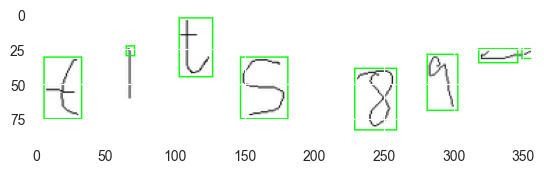

In [104]:
with open('knn_model.pkl', 'rb') as file:
    model = pickle.load(file)

restored_string = {}

for string, image_path in generated_images_paths.items():
    restored_text, cer = restore_text_from_image(image_path, model, string)

    if restored_text:
        restored_string[string] = restored_text

In [105]:
from pandas import DataFrame, concat
df_results = DataFrame(results, columns=['Исходная строка', 'Предсказанная строка', 'CER'])
df_results

,Исходная строка,Предсказанная строка,CER
0,727t0 06t)1,"[7, 2, 1, t, 0, 0, 0, 1, +, y]",0.545455
1,(5y w(1,"[+, y, 1, ), 6, (]",0.857143
2,128 wy99(,"[y, 2, ,, -, 0, 1, 2, +, ,, 5]",1.000000
3,X51T) 2hh,"[X, -, 1, t, ), 0, 2, 1]",0.555556
4,+(69y 2(1,"[+, 0, 6, 2, ,, 1, 5, 1]",0.666667
5,"+4,9) 51)","[+, +, 8, X, 7, 1, X, 3]",0.888889
6,4yTh( 410,"[-, 1, t, 2, 6, 2, 9, 2]",1.000000
7,56w5 (3y17,"[(, (, 1, y, 2, (, 1, 1, ,]",0.800000
8,"5)X t,))","[), 1, 9, (, +, ), 8]",0.750000
9,"T,t5 89-","[+, 2, +, 3, 5, 1, w, 8]",1.000000


РАСПОЗНАВАНИЕ
Итак, к данному этапу Вы из массива изображений "восстановили" текст.
Случайно удалите некоторые символы,и случайно добавьте символы в результат распознавания.
Рассчитайте метрику CER.

In [106]:
def modify_text(text, delete_prob=0.1, insert_prob=0.1):
    modified_text = []
    for char in text:
        if random.random() > delete_prob:
            modified_text.append(char)

        if random.random() < insert_prob:
            modified_text.append(chr(random.randint(32, 126)))

    return ''.join(modified_text)

In [107]:
for idx, row in df_results.iterrows():
    original_text = row["Исходная строка"]
    predicted_text = row["Предсказанная строка"]

    modified_predicted_text = modify_text(predicted_text)

    cer = calculate_cer(original_text, modified_predicted_text)

    df_results.at[idx, "Предсказанная строка"] = modified_predicted_text
    df_results.at[idx, "CER"] = cer

df_results

,Исходная строка,Предсказанная строка,CER
0,727t0 06t)1,721t001+y,0.545455
1,(5y w(1,+y1)6(c,0.857143
2,128 wy99(,"yu20,-0w2+,5",1.111111
3,X51T) 2hh,X-kt)02D,0.666667
4,+(69y 2(1,"+062,151",0.666667
5,"+4,9) 51)",++8uX7X3,0.888889
6,4yTh( 410,-1t26292,1.000000
7,56w5 (3y17,"((1y(1,",0.800000
8,"5)X t,))",)19(2+)8,0.875000
9,"T,t5 89-",2k+351w8,1.000000
